## <img src="uomlogo.png" align="left"/><br><br>
# PHYS20762 - Project 3 - Monte Carlo Techniques
# Penetration of neutrons Through Shielding

Matylda Hoffman <br>
University of Manchester  
April 2021

In [96]:
# Initialise the code and import useful python libraries
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from mpl_toolkits.mplot3d import Axes3D
import math
# Import Avogadro's constant
from scipy.constants import N_A

### Introduction
The aim of this project is to, using a random number generator, imitate a path taken by a neutron travelling through slabs of water, lead, and graphite. This simulation of a random walk can then be used to obtain probabilities related to the three different outcomes of a neutron scattering through these media. Those are: reflection, absorption, and transmission.

In this project I will:<br>
1. Discuss different methods of generating random numbers,
2. Investigate how nenutrons penetrate different types of metrials,
3. Find the attenuation depth of different media,
4. For each investigated material I will determine the macroscopic absorption and scattering cross-sections and the resultant mean free path $\lambda$,
5. Inspect how probability of transmission is affected when I change the thickness of the media.

#### Generating random numbers

It is very hard to achieve true randomness in programming. There are algorithms which immitate a random output by drawing numbers from different distributions. A simple example of such is the uniform distrubution. After specfying a range $a<x<b$ all numbers within that range have an equal probability density $P(x)=\frac{1}{b-a}$. Below are exmaples of plots showing the probability density function(PDF) and the cumulative distribution function(CDF) for a uniform distribution obtained from https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.Uniform.html.

##### <img src="uniform distribution.png" width="500" align="center"/>

#### Testing for Uniformity - Chi squared Test

Here I will test a python function which generates a pseudo-random array from such a distribution and check that its outputs are uniform over a chosen range. A distribution is uniform when the probability of each sample being selected is $\frac{1}{N}$ where $N$ is the number of samples being taken. I will assess the uniformity of distribution of the generated numbers by performing a chi-squared test which compares each sample to the expected value by:
$$\chi^{2}=\sum^{n}_{i=1}\frac{(O_{i}-E_{i})^{2}}{E_{i}}$$
where $E_{i}$ is the expected value from the distribution and $O_{i}$ is the observed.

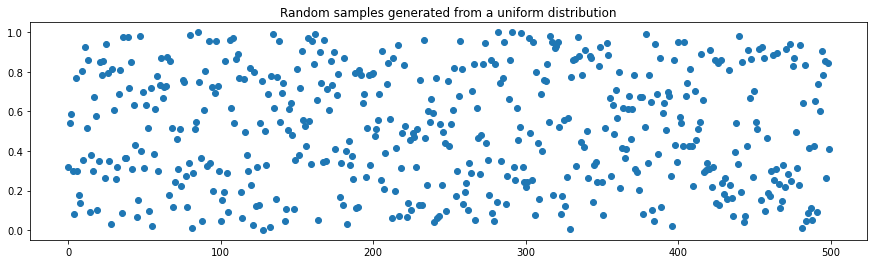

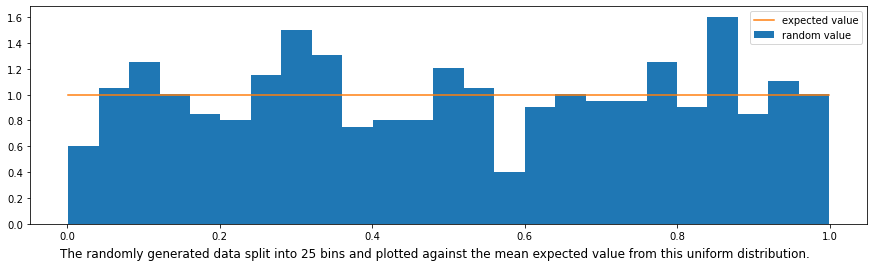

The reduced chi squared value of the random distribution compared to a uniform distribution
in the same range is:  0.16872911349236477


In [97]:
def chi_squared(observed, expected):
    return np.sum((observed-expected)**2/expected)/len(observed)

# Create 500 uniformly distributed pseudo-random numbers in the range (1,10].
dist = np.random.uniform(0,1,500)

# Display a scatter plot of the random points to visualise the spread
plt.figure(figsize=(15,4))
plt.scatter(np.arange(0,len(dist)), dist)
plt.title('Random samples generated from a uniform distribution')
plt.show()

# Check for uniformity of distribution using a bar chart
plt.figure(figsize=(15,4))
dist_binned, bins, patches = plt.hist(dist, 25, density=True, label='random value')
plt.plot(bins, np.ones_like(bins), label='expected value')
plt.legend()
caption = 'The randomly generated data split into 25 bins and plotted against the mean expected value from this uniform distribution.'
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

expected_value_array = len(dist)*[0.5*(1-0)]
print('The reduced chi squared value of the random distribution compared to a uniform distribution\nin the same range is: ', chi_squared(dist, expected_value_array))

The reduced chi squared value obtained from the distribution is very small suggesting a highly good approximation. So the randomly generated numbers are uniformly distributed. <br>
Another way to chack whether the distribution generated is uniform is through calculating the standard deviation of grouped samples after generating the array a number of times. Here I will produce ten histograms of a uniform distribution with the same number of bins each and find the standard deviation of each bin value. If the distribution is truly uniform then the standard deviation should be roughly equal to the expected number of samples in each bin - here $\frac{1}{25}x500 = 4.47213595499958$.

In [98]:
bin_values = np.array([])
a = 500*1/25
sigma = np.sqrt(a)
print('{a:<10}'.format(a='Bin number'), '{a:<10}'.format(a='Bin value'), '{a:<10}'.format(a='sqrt(expected value)'))
print('--------------------------------------------------------')
for i in range(0,10):
    densities, bin_edges = np.histogram(np.random.uniform(0,1,500), 25)
    bin_values = np.append(bin_values, densities)
    print('{:<10}'.format(i+1), '{:<10.2f}'.format(np.std(densities)), '{:<10}'.format(sigma))


Bin number Bin value  sqrt(expected value)
--------------------------------------------------------
1          4.05       4.47213595499958
2          4.06       4.47213595499958
3          3.91       4.47213595499958
4          4.66       4.47213595499958
5          4.14       4.47213595499958
6          4.74       4.47213595499958
7          4.37       4.47213595499958
8          3.87       4.47213595499958
9          4.55       4.47213595499958
10         4.76       4.47213595499958


Because the standard deviations of bar chart densities are around the square root of the expencted values the distribution obtained from the numpy.random.uniform() function can be deemed truly uniform.

### Generating a Random 3D array
Now lets generate an array of points in three dimensions $(x,y,z)$ and examine it for the spectral problem when using a uniform distribution.

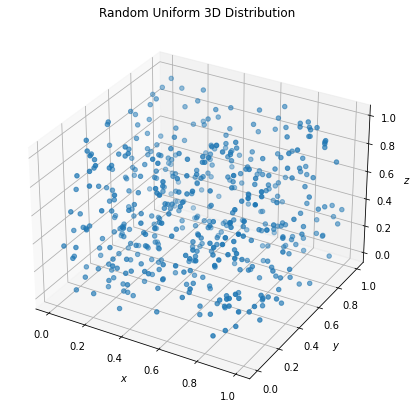

In [99]:
# A function which will generate an array of randomly and uniformly distributed 3D coordinates
def three_dimensional_array_uniform(length):
    xs = np.random.uniform(0,1,length)
    ys = np.random.uniform(0,1,length)
    zs = np.random.uniform(0,1,length)
    return (xs,ys,zs)
    
def three_dimensional_plot(x, y, z, title):
    ax = plt.axes(projection='3d')
    ax.scatter(x, y, z, cmap='Greens', marker='o')
    plt.title(title)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

(x_values_uniform, y_values_uniform, z_values_uniform) = three_dimensional_array_uniform(500)
plt.figure(figsize=(7,7))
three_dimensional_plot(x_values_uniform, y_values_uniform, z_values_uniform, 'Random Uniform 3D Distribution')
plt.show()


Above samples are all uniformly spread, however we can choose any other distribution. When using the exponential distribution the majority of samples will be accumulated near 0 and as you get to larger values, they will exponentially get less abundant. 

### Probability Exponential Distribution

The exponential distribution has one parameter- the rate of decay $\lambda$. We will be working with a probability probability density function (PDF) which follows:
$$f(x)=e^{-\frac{x}{\lambda}}$$
The probability of samples being chosen using this distribution decreases as the numbers increase in size and hence we get the following cumulative density function (CDF- which is just the integral of the distribution):
$$F(x)=P(x<X)=\int_{0}^{x}f(x)dx = 1-\lambda e^{-\frac{x}{\lambda}}$$
This function can be inverted so that we generate x instead of inputting it. Solving F(x)=y for x gives:
$$x=-\lambda \ln{(\frac{1-y}{\lambda})}$$
Below I have displayed an example graph of an exponential distribution, together with its corresponding cumulative density function (CDF)

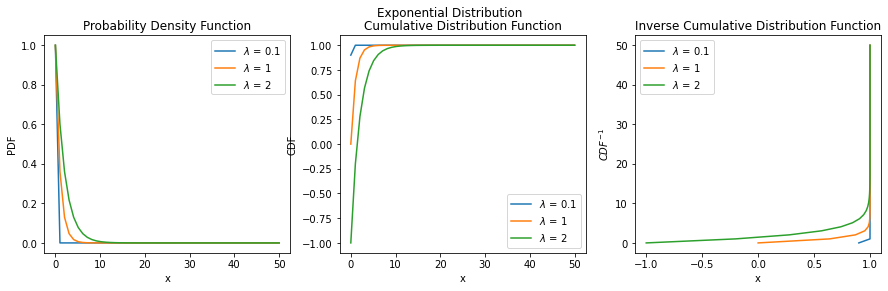

In [4]:
def plotting_twoD_data(x, y, title, xname, yname):
    label_name = '$\lambda$ = '+str(l)
    plt.plot(x,y, label=label_name)
    plt.title(title)
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.legend()

# Plotting an example exponential distribution and the corresponding cumulative distribution function
lambda_rate = [0.1, 1, 2]
xs = np.linspace(0,50)
plt.figure(figsize=(15,4))
plt.suptitle('Exponential Distribution')
plt.subplot(1,3,1)
for l in lambda_rate:
    plotting_twoD_data(xs, np.exp(-xs/l), 'Probability Density Function', 'x', 'PDF')
plt.subplot(1,3,2)
for l in lambda_rate:
    plotting_twoD_data(xs, 1-l*np.exp(-xs/l), 'Cumulative Distribution Function', 'x', 'CDF')
plt.subplot(1,3,3)
for l in lambda_rate:
    plotting_twoD_data(1-l*np.exp(-xs/l), -l*np.log((l*np.exp(-xs/l))/l), 'Inverse Cumulative Distribution Function', 'x', '$CDF^{-1}$')
plt.show()

Looking at the above distributions it is noticable why the inverse cumulative distribution is useful when generating random numbers. Its x-axis varies between 0 and 1 which corresponds to any probability range. This way, increasingly-probable numbers (nearer to P(x<X)=1) are chosen more frequently as they subtend a larger area under the curve. 

#### Generating Exponentially Distributed Random Numbers 

In order to generate an array of random numbers which will be exponentialy distributed we first need to generate an array of random y-values. This can be done using the previously-discussed uniform distribution. Those uniformly-spaced numbers can then be substituted into $x=-\lambda \ln{(\frac{1-y}{\lambda})}$ to obtain an exponentially-shaped array.

Now lets generate a 3D array of exponentially distributed numbers and plot them.

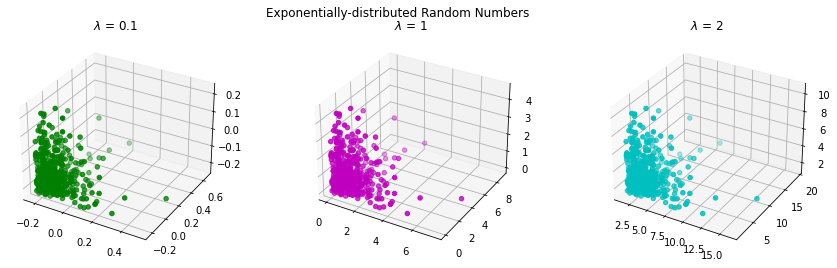

In [5]:
def inverse_exponential_CDF(n, l):
    return -l*np.log((1-n)/l)

def three_dimensional_array_exponential(x_uni, y_uni, z_uni, lamb):
    x = inverse_exponential_CDF(x_uni, lamb)
    y = inverse_exponential_CDF(y_uni, lamb)
    z = inverse_exponential_CDF(z_uni, lamb)
    return (x,y,z)

colour_list = ['g', 'm', 'c']
fig = plt.figure(figsize=(15,4))
fig.suptitle('Exponentially-distributed Random Numbers')
# Take the uniformly distributed 3D array from before and input it into the exponential inverse CDF
# Use the same array of lambda values as above for comparison
for i, lambda_ in enumerate(lambda_rate):
    ax = fig.add_subplot(1,3,i+1, projection='3d')
    (x_expo, y_expo, z_expo) = three_dimensional_array_exponential(x_values_uniform, y_values_uniform, z_values_uniform, lambda_)
    ax.scatter(x_expo, y_expo, z_expo, c=colour_list[i], marker='o')
    plt.title('$\lambda$ = '+str(lambda_))
plt.show()

Looking at the randomly generated numbers above, they all visibly follow exponential distributions. The difference between them is the decay rate used, $\lambda$, which causes the range of generated values to vary significantly (in exponential proportion). The scale when using a value of $\lambda$ between 0 and 1 ranges be from the negative to few very small positive numbers, whereas increasing $\lambda$ to e.g.2 will produce points scattered between 0 and about 20, which is nearly 40 times larger.

## Investigation- Penetration of different shieldings by thermal neutrons

In the following investigation we will inspect th attenuation depth of different materials using thermal neutrons. Thermal neutrons are free neutrons not bound to any atom and possessing kinetic energy equal to thaat of the average kinetic energy of their ambient environment. In this simulation a source of such neutrons is placed right by a slab made of some material. The random free path that a particle will follow through that slab will depend on the compostion and density of the material. Different media have different absorption and scattering cross-sections which also impacts the attenuation depth. 

In [6]:
# Thermal Neutron data for different materials
# Absorption cross-sections, units: [cm^2] converted from barns
WATER_ABSORPTION_XS = 0.6652*10**(-24)
LEAD_ABSORPTION_XS = 0.158*10**(-24)
GRAPHITE_ABSORPTION_XS = 0.0045*10**(-24)

# Scattering cross-sections, units: [cm^2] converted from barns
WATER_SCATTERING_XS = 103.0*10**(-24)
LEAD_SCATTERING_XS = 11.221*10**(-24)
GRAPHITE_SCATTERING_XS = 4.74*10**(-24)

# Density of materials, units [g/cm^3]
WATER_DENSITY = 1.00
LEAD_DENSITY = 11.35
GRAPHITE_DENSITY = 1.67

# Molar masses, units: [g/mol]
WATER_M = 18.01528
LEAD_M = 207.2000
GRAPHITE_M = 12.01070

Firstly I will test out the random exponential distribution I have implemented above to immitate a random free path of a neutron travelling through water. However I will initially ignore scattering and only focus on absorption.
### Particle Absorption

##### <img src="slab diagram.png" height="100" align="center"/>
The image above (sourced from course material: video 10) depicts a cross-section of a material with interactive particles of size $\sigma$ (also cross sectional area). The slice considered has thickness L and thermal neutrons are fired from right by the surface of the slab with intensity $I$. However, as the particles travel through the slab they are absorbed and hence their intensity decreases. The rate of change of intensity depends on the number of absorbing particles within the material $n=\frac{\rho N_A}{M}$, where $\rho$ is the desity of the material, $N_{A}$ is Avogadro's number, and $M$ is the molar mass of that substance. Consequently, the number of neutrons absorbed in a thin layer, $L$, of the material is $N_{L}=n\sigma IL$, where I is the nuetron intensity and $\sigma$ corresponds to the microscopic absorption cross-section of a particle within the target material. 
We can differentiate to obtain the rate of absorption per unit thickness: $R=-\frac{dI}{dx}=n\sigma I$.
Finally, this allows us to write the intensity as an exponential function of distance $x$:
$$I(x)=e^{-n\sigma x}=e^{-\frac{x}{\lambda}}.$$
$\lambda$ corresponds to the mean free path taken by a neutron, which is a mean distance a neutron can travel before colliding with another particle. It can be calculated from the total macroscopic cross-section $\Sigma=n\sigma$ by taking its reciprocal: $\lambda=\frac{1}{\Sigma}$. <br><br>
$\lambda_{T}$ is the total mean free path defined by: 
$$\lambda_{T}=\frac{1}{\Sigma_{T}}$$ 
and $\Sigma_{T}=\Sigma_{1}+\Sigma_{2}+\Sigma_{3}+...=n_{1}\sigma_{1}+n_{2}\sigma_{2}+n_{3}\sigma_{3}+...$ corresponds to the total macroscopic cross-sectional area of interactive particles in the medium. In this first case we are only considering the absorbing particles, and we will involve scattering later. This value can be worked out from the thermal neutron data provided in the project brief. 

### Characteristic attenuation depth of water (assuming no scattering)

Attenuation depth $\lambda$ is the a material-specific distance at which the intensity of the incident beam of neutrons drops to $\frac{1}{e}$. Firstly, I will calculate the errors on generated random numbers due to the fluctuations in frequency density of the generated uniform distribution. I will do that using histogram data of ten different rounds of generated random numbers. I will produce a mean for each bin value with a standard error on it. Below we can also see an example of how the distribution of exponentially generated random numbers (here x-coordinates) varies each time we create an array. 

After first calculating the mean free path of neautrons in water (considering only absorption) I will generate an array of uniformly distributed random numbers, $u_{i}$. I will then substitute those into the formula for an exponentially distributed array of step-sizes
$$s_{i}=-\lambda_{T}\ln{u_{i}}.$$
After averaging a number of generated repeates I will consider the mean and standard deviation to produce a weighted array with proportional errors on each bin $\frac{s.t.d.}{mean}$. Next I will linearise the exponentially distributed data by taking the natural logarithm, and fit a straight line to it. The gradient of this line will provide an estimate for the attenuation depth of water.

In [12]:
# Number density of water, from density data provided in the project brief
WATER_n = WATER_DENSITY*N_A/WATER_M
# Macroscopic absorption cross-section of water 
water_absorption_macro_xs = WATER_n*WATER_ABSORPTION_XS
# Calculating the mean free path
water_mfp_absorption = 1/water_absorption_macro_xs
print('Mean free path of water considering absorption only = ',water_mfp_absorption)

Mean free path of water considering absorption only =  44.97155178303617


44
49 49 49


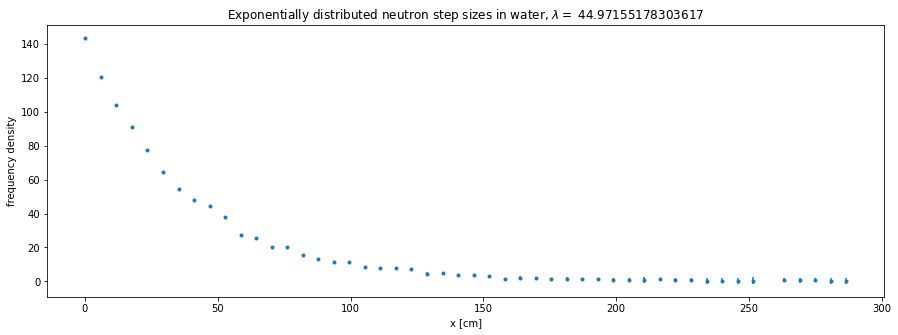

[0.18082807 0.13548199 0.10692208 0.08708074 0.08134406 0.06121895
 0.06739082 0.11063265 0.18358287 0.14473444 0.24744016 0.17269065
 0.30688509 0.24333081 0.25515432 0.32996324 0.37668264 0.27235394
 0.31234752 0.46117613 0.26447041 0.51110125 0.66792572 0.58759919
 0.71428571 0.40460856 0.5483871  0.85714286 1.09544512 0.74638691
 0.72843136 1.16428328 0.75514762 1.03252879 1.35628396 0.77459667
 1.69967317 1.03252879 0.93541435 1.11574995 2.         1.52752523
 2.         2.13437475 1.22474487 1.34164079 1.1055416  2.
 2.        ]


In [13]:
# 1. Generate an exponentially distributed array of random numbers all with the same lambda, equal to the mean free path 
# of water calculated from data in the brief, but different random uniform inputs.
# An array of 10 different arrays for standard deviation calculations
# 2. Plot a histogram for each of the 10 trials and compute the standard deviation and hence the error

number_of_random_numbers_generated = 1000
number_of_bins = 50 
frequency = np.array([])

# Generates 10 arrays of 1000 uniformly distrubuted numbers
for i in range(0,10):
    
    u_i = np.random.uniform(0,1,number_of_random_numbers_generated)
    # Substitute these into the step size equation to obtain  exponentially distributed random arrays
    s_i = -water_mfp_absorption*np.log(u_i)
    # Produce a histogram of the data to find the standard deviation
    frequency_binned, s_i_binned = np.histogram(s_i, number_of_bins)
    frequency = np.append(frequency, frequency_binned)

frequency_average = np.array([])
frequency_std = np.array([])

# Calculate the mean and standard deviation of each bin
i = 0
# Itarate through the bins
while i < number_of_bins:
    step_size_array = np.array([])
    # Iterate through the 10 values for each bin
    for j in range(0, 10):
        step_size_array = np.append(step_size_array, frequency[i+number_of_bins*j])
    if np.mean(step_size_array) != 0:
        frequency_average = np.append(frequency_average, np.mean(step_size_array))
        frequency_std = np.append(frequency_std, np.std(step_size_array))
        i += 1
    else:
        print(i)
        s_i_binned = np.delete(s_i_binned, i)
        number_of_bins -= 1

print(len(s_i_binned[:-1]), len(frequency_average), len(frequency_std))

plt.figure(figsize=(15,5))
plt.title('Exponentially distributed neutron step sizes in water, $\lambda=$ '+str(water_mfp_absorption))
plt.errorbar(s_i_binned[:-1], frequency_average, yerr=frequency_std/frequency_average, fmt='.')
plt.xlabel('x [cm]')
plt.ylabel('frequency density')
plt.show()

print(frequency_std/frequency_average)


<ipython-input-14-67ed6f000619>:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.errorbar(s_i_binned[:-1], frequency_linear, yerr=np.log(frequency_std)/frequency_linear, fmt='.')


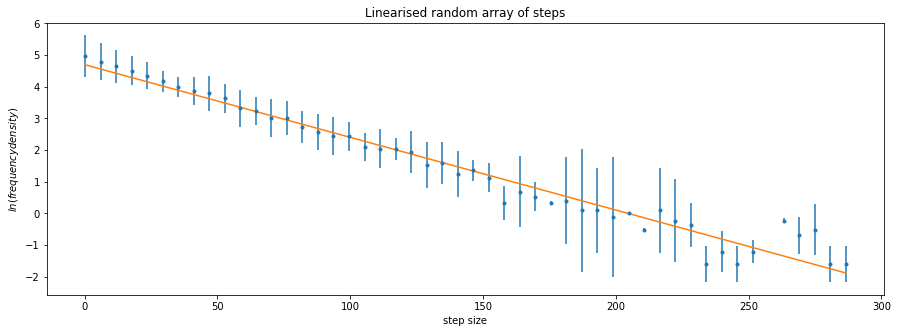

The attenuation depth of water when only considering absorption is =  43.55032273307008 +/- 1.2097435273142443


In [14]:
# Linearise the data (=s_i_binned/lambda) where lambda is the fitted attenuation depth of water for absorption
frequency_linear = np.log(frequency_average)
parameters, cov = np.polyfit(s_i_binned[:-1], frequency_linear, 1, cov=True)

# Display the fit 
fig = plt.figure(figsize=(15,5))
plt.errorbar(s_i_binned[:-1], frequency_linear, yerr=np.log(frequency_std)/frequency_linear, fmt='.')
plt.plot(s_i_binned[:-1], parameters[0]*s_i_binned[:-1]+parameters[1])
plt.title('Linearised random array of steps')
plt.xlabel('step size')
plt.ylabel('$ln(frequency density)$')
plt.show()

fitted_mfp_water = -1/parameters[0]
fmt_water_error = abs((np.sqrt(cov[0][0])/parameters[0])*fitted_mfp_water)
print('The attenuation depth of water when only considering absorption is = ', fitted_mfp_water, '+/-', fmt_water_error)

### Generating isotropic unit vectors
#### Random uniform distribution of points on a sphere

Here I will generate an array of vectors uniformly distributed over a sphere of radius $r$. Coordinates of each point, $(x,y,z)$, can be describes in spherical polars as:
$$x_{i}=r\sin{\theta_{i}}\cos{\phi_{i}}$$
$$y_{i}=r\cos{\theta_{i}}\sin{\phi_{i}}$$
$$z_{i}=r\cos{\theta_{i}}$$
where $\theta$  and $\phi$ are the polar and azimuthal angles on surface of a sphere respectively. They are uniformly, randomly generated in the following ranges:
$$0<\theta_{i}<\pi$$
$$0<\phi_{i}<2\pi.$$

<IPython.core.display.Javascript object>


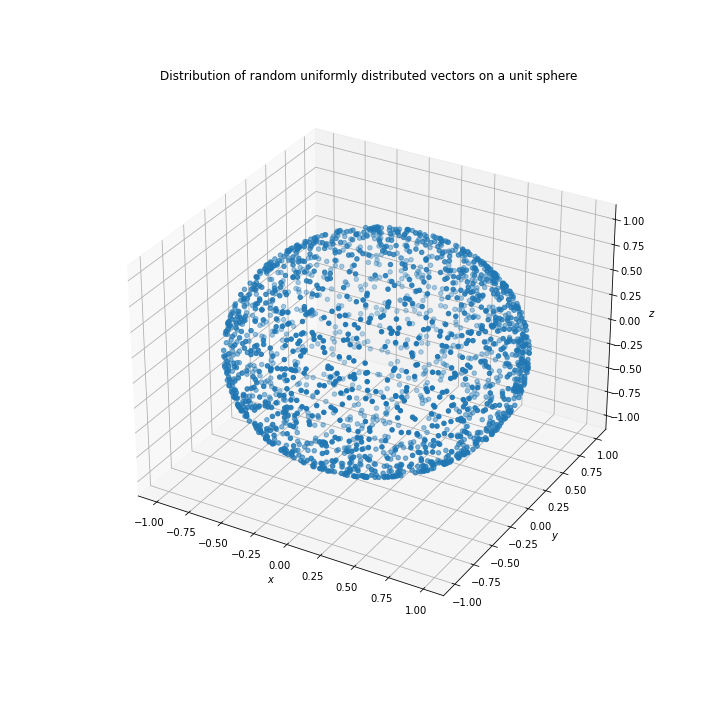

Visually the points look uniformly distributed over the unit sphere.


In [16]:
# A function which can be called to generate an array of exponentially distributed random numbers. Array size = n
def random_exponential_array(lambda_, min_u, max_u, n):
    return -lambda_*np.log(np.random.uniform(min_u, max_u, n))

# Number of random isotropic vectors to be generated
number_of_points = 2000
# Radius of which to distribute the points
radius = 5

def random_isotropic_unit_vectors(r, n):
    # Generate n uniformly distributed random angular coordinates
    theta = np.arccos(1-2*np.random.uniform(0, 1, n))
    phi = np.random.uniform(0, 2*np.pi, n)
    # Convert to cartesian 
    xs = r*np.sin(theta)*np.cos(phi)
    ys = r*np.sin(theta)*np.sin(phi)
    zs = r*np.cos(theta)
    normalization_costant = np.sqrt(xs**2+ys**2+zs**2)
    return (xs/normalization_costant, ys/normalization_costant, zs/normalization_costant)

%matplotlib notebook
(unit_x, unit_y, unit_z) = random_isotropic_unit_vectors(radius, number_of_points)
plt.figure(figsize=(10,10))
three_dimensional_plot(unit_x, unit_y, unit_z, 'Distribution of random uniformly distributed vectors on a unit sphere')

plt.show()

print('Visually the points look uniformly distributed over the unit sphere.')


<IPython.core.display.Javascript object>


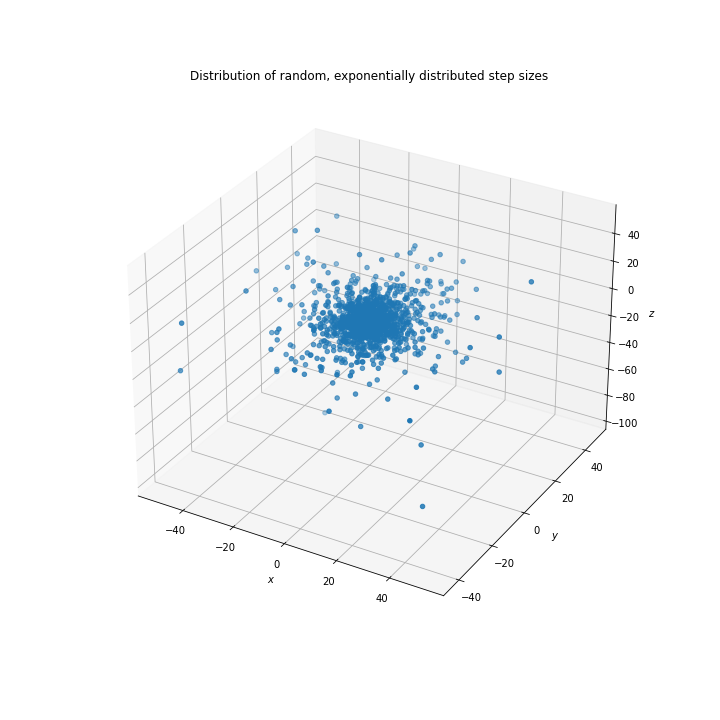

In [17]:
# Generating exponentially distributed isotropic steps
def exponential_isotropic_steps(radii, lam):
    x_step_sizes = np.zeros(len(radii))
    y_step_sizes = np.zeros(len(radii))
    z_step_sizes = np.zeros(len(radii))
    # Take an exponential array of radial lengths and generate angular coordinates for each using a spherically uniform distribution
    for i, r in enumerate(radii):
        theta = np.arccos(1-2*np.random.uniform(0, 1, 1))
        phi = np.random.uniform(0, 2*np.pi, 1)
        # Convert to cartesian 
        x_step_sizes[i] = r*np.sin(theta)*np.cos(phi)
        y_step_sizes[i] = r*np.sin(theta)*np.sin(phi)
        z_step_sizes[i] = r*np.cos(theta)
    # Returns an array of random step coordinates
    return x_step_sizes, y_step_sizes, z_step_sizes
    
step_x, step_y, step_z = exponential_isotropic_steps(random_exponential_array(10, 0, 1, number_of_points), lambda_) # Used example lambda = 10
# Plot the distribution of step sizes of n neutrons
plt.figure(figsize=(10,10))
three_dimensional_plot(step_x, step_y, step_z, 'Distribution of random, exponentially distributed step sizes')

plt.show()


### Investigating penetration of water, lead and graphite by thermal neutrons considering absorption and scattering
In this investigation neutrons will start their journey at $x=0$ and move straight into the medium by taking their first step in the positive $x$ direction. Later steps are drawn from the distribution $e^{-\frac{x}{\lambda}}$. Using the values for total mean free paths of each material (calculated below) I will generate a sequence of random steps the neutron takes and check whether it gets absorbed, scattered, reflected ($x<0$), or transmitted ($x>T$), where $T$ is the thickness of the test slab. 

In [18]:
# Calculating macroscopic cross-sections of the investigated materials
# n = number of absorbing/scattering particles

# WATER
WATER_n = WATER_DENSITY*N_A/WATER_M
WATER_MACRO_XS_TOTAL =  WATER_n*(WATER_ABSORPTION_XS+WATER_SCATTERING_XS)
WATER_MFP_TOTAL = 1/WATER_MACRO_XS_TOTAL
WATER_P_ABSORPTION = WATER_n*WATER_ABSORPTION_XS/WATER_MACRO_XS_TOTAL
WATER_P_SCATTERING = WATER_n*WATER_SCATTERING_XS/WATER_MACRO_XS_TOTAL

# LEAD
LEAD_n = LEAD_DENSITY*N_A/LEAD_M
LEAD_MACRO_XS_TOTAL = LEAD_n*(LEAD_ABSORPTION_XS+LEAD_SCATTERING_XS)
LEAD_MFP_TOTAL = 1/LEAD_MACRO_XS_TOTAL
LEAD_P_ABSORPTION = LEAD_n*LEAD_ABSORPTION_XS/LEAD_MACRO_XS_TOTAL
LEAD_P_SCATTERING = LEAD_n*LEAD_SCATTERING_XS/LEAD_MACRO_XS_TOTAL

# GRAPHITE
GRAPHITE_n = GRAPHITE_DENSITY*N_A/GRAPHITE_M
GRAPHITE_MACRO_XS_TOTAL = GRAPHITE_n*(GRAPHITE_ABSORPTION_XS+GRAPHITE_SCATTERING_XS)
GRAPHITE_MFP_TOTAL = 1/GRAPHITE_MACRO_XS_TOTAL
GRAPHITE_P_ABSORPTION = GRAPHITE_n*GRAPHITE_ABSORPTION_XS/GRAPHITE_MACRO_XS_TOTAL
GRAPHITE_P_SCATTERING = GRAPHITE_n*GRAPHITE_SCATTERING_XS/GRAPHITE_MACRO_XS_TOTAL

print('{a:<15}'.format(a='Material'), '{a:<30}'.format(a='Probability of absorption'), '{a:<20}'.format(a='Probability of scattering'))
print('---------------------------------------------------------------------------')
print('{a:<15}'.format(a='Water'), '{:<30}'.format(WATER_P_ABSORPTION), '{:<20}'.format(WATER_P_SCATTERING))
print('{a:<15}'.format(a='Lead'), '{:<30}'.format(LEAD_P_ABSORPTION), '{:<20}'.format(LEAD_P_SCATTERING))
print('{a:<15}'.format(a='Graphite'), '{:<30}'.format(GRAPHITE_P_ABSORPTION), '{:<20}'.format(GRAPHITE_P_SCATTERING))


Material        Probability of absorption      Probability of scattering
---------------------------------------------------------------------------
Water           0.006416811041699625           0.9935831889583003  
Lead            0.013885227172862292           0.9861147728271378  
Graphite        0.00094846664558963            0.9990515333544103  
0.28857395004375297
2.664028641665988
2.517158105427453


The funtion below will track the path of a neutron through comparing the randomly generated number $u_{i}$ to the probability of absorption $P_{a}=\frac{\Sigma_{absorption}}{\Sigma_{Total}}$. The probabilities of absorption for the three materials are listed in the table above. From those we may hypothesize that most absorption will occur in lead and least in graphite. 

<IPython.core.display.Javascript object>


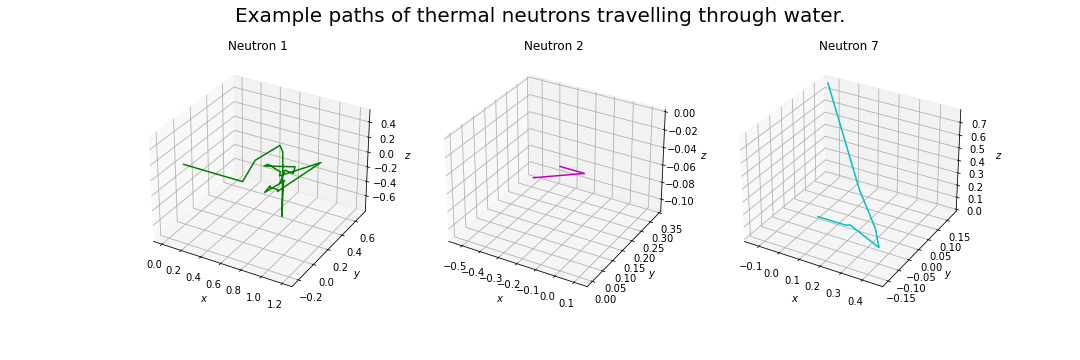

Neutron number 1 has been absorbed after 22 steps.
Neutron number 2 has been reflected after 1 steps.
Neutron number 3 has been reflected after 3 steps.
Neutron number 4 has been reflected after 1 steps.
Neutron number 5 has been reflected after 12 steps.
Neutron number 6 has been reflected after 1 steps.
Neutron number 7 has been reflected after 6 steps.
Neutron number 8 has been reflected after 2 steps.
Neutron number 9 has been absorbed after 11 steps.
Neutron number 10 has been reflected after 2 steps.
0.00% of the neutrons have been transmitted.
20.00% of the neutrons have been absorbed.
80.00% of the neutrons have been reflected.


In [19]:
# Path of a thermal neutron travelling through a material
# Takes in thickness T, probability of absorption P_a, mean free path in that material mfp

def neutron_path(T, P_a, mfp, neutron, n_a, n_t, n_r):
    # Counter for the number of steps
    n = 0 
    # Initial coordinates
    x = np.array([0.])
    y = np.array([0.,0.])
    z = np.array([0.,0.])
    is_absorbed = False
    while x[-1] >= 0 and x[-1] < T and is_absorbed == False:
        # Initial step has to be in the positive x direction
        if n == 0:
            x = np.append(x, random_exponential_array(mfp, 0, 1, 1))
        else:
            s_x, s_y, s_z = exponential_isotropic_steps(random_exponential_array(mfp, 0, 1, 1), mfp)
            x = np.append(x, x[-1]+s_x)
            y = np.append(y, y[-1]+s_y)
            z = np.append(z, z[-1]+s_z)
            
        if x[-1] < 0:
            n_r += 1
            if N < 20:
                print('Neutron number '+str(neutron)+' has been reflected after '+str(n)+' steps.')
            break
        elif x[-1] > T:
            n_t += 1
            if N < 20:
                print('Neutron number '+str(neutron)+' has been transmitted after '+str(n)+' steps.')
            break
        else:
            u = np.random.uniform(0,1,1)
            if u<P_a:
                is_absorbed = True
                n_a += 1
                if N < 20:
                    print('Neutron number '+str(neutron)+' has been absorbed after '+str(n)+' steps.')
                break
        n += 1
    return x, y, z, n_a, n_t, n_r

def neutron_history(neutron_number, p_absorption, mfp_total, material):
    fig = plt.figure(figsize=(15,5))
    fig.suptitle('Example paths of thermal neutrons travelling through '+material, fontsize=20)
    i = 1
    # Add counters for how many neutrons are bsorbed, trnasmitted and reflected
    n_a, n_t, n_r = 0, 0, 0
    # Consider each neutron's path
    for neutron in range(1, neutron_number+1):
        x_path, y_path, z_path, n_a, n_t, n_r = neutron_path(thickness, p_absorption, mfp_total, neutron, n_a, n_t, n_r)
        # plot a path of a few example neutrons (e.g. the 1st, the 2nd, and the 7th)
        if neutron == 1 or neutron == 2 or neutron == 7:
            ax = fig.add_subplot(1,3,i, projection='3d')
            ax.plot3D(x_path, y_path, z_path, c=colour_list[i-1])
            plt.title('Neutron '+str(neutron))
            ax.set_xlabel('$x$')
            ax.set_ylabel('$y$')
            ax.set_zlabel('$z$')
            i += 1
    plt.show()
    neutron_path_analysis(n_a, n_t, n_r)
    
def neutron_path_analysis(n_absorbed, n_transmitted, n_reflected):
    print("{:.2f}".format(n_transmitted/N*100)+'% of the neutrons have been transmitted.')
    print("{:.2f}".format(n_absorbed/N*100)+'% of the neutrons have been absorbed.')
    print("{:.2f}".format(n_reflected/N*100)+'% of the neutrons have been reflected.')

# Choose how many neutrons to consider and the thickness of the tested medium
N = 10
thickness = 10 #[cm]

neutron_history(N, WATER_P_ABSORPTION, WATER_MFP_TOTAL, 'water.')

In water most thermal neutrons are reflected due to the probability of absorption being very low and transmission being rather unpropbable in a thick material.  The first step is always perpendicular to the medium - in the positve $x$ direction, When considering 10cm, as asked for in the proect brief, it is more likely that a neutron makes its way back to the plane of entry, than its random walk taking it all the way through the slab. Hence, most thermal neutron scattered in water are reflected, then absorbed, and very rarely some are transmitted. 

Now consider two different, denser media: lead and graphite. 

<IPython.core.display.Javascript object>


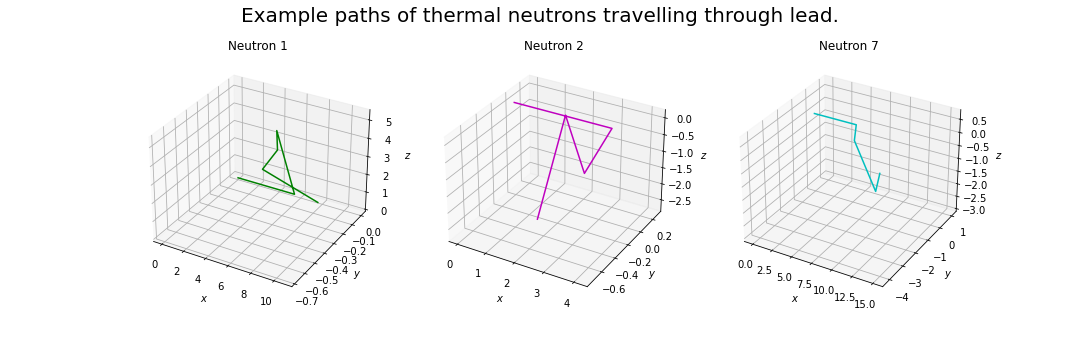

Neutron number 1 has been transmitted after 4 steps.
Neutron number 2 has been absorbed after 3 steps.
Neutron number 3 has been transmitted after 7 steps.
Neutron number 4 has been reflected after 1 steps.
Neutron number 5 has been absorbed after 10 steps.
Neutron number 6 has been reflected after 5 steps.
Neutron number 7 has been transmitted after 3 steps.
Neutron number 8 has been transmitted after 4 steps.
Neutron number 9 has been transmitted after 21 steps.
Neutron number 10 has been reflected after 3 steps.
50.00% of the neutrons have been transmitted.
20.00% of the neutrons have been absorbed.
30.00% of the neutrons have been reflected.


<IPython.core.display.Javascript object>


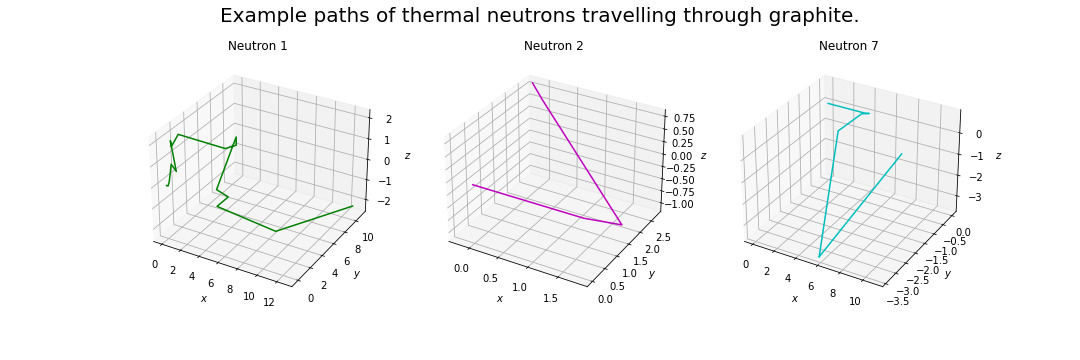

Neutron number 1 has been transmitted after 15 steps.
Neutron number 2 has been reflected after 3 steps.
Neutron number 3 has been reflected after 2 steps.
Neutron number 4 has been transmitted after 12 steps.
Neutron number 5 has been transmitted after 7 steps.
Neutron number 6 has been reflected after 6 steps.
Neutron number 7 has been transmitted after 6 steps.
Neutron number 8 has been reflected after 9 steps.
Neutron number 9 has been transmitted after 8 steps.
Neutron number 10 has been reflected after 22 steps.
50.00% of the neutrons have been transmitted.
0.00% of the neutrons have been absorbed.
50.00% of the neutrons have been reflected.


In [20]:
# Now simulate the same number of neutrons going through lead and graphite
neutron_history(N, LEAD_P_ABSORPTION, LEAD_MFP_TOTAL, 'lead.')
neutron_history(N, GRAPHITE_P_ABSORPTION, GRAPHITE_MFP_TOTAL, 'graphite.')

In all three materials the thermal neutrons are most likely to be reflected or transmitted, and very few, if any, neutrons are absorbed.

Now lets take a larger sample of neutrons (1000) and look at the proportion of them that are transmitted, reflected, and absorbed.

<IPython.core.display.Javascript object>


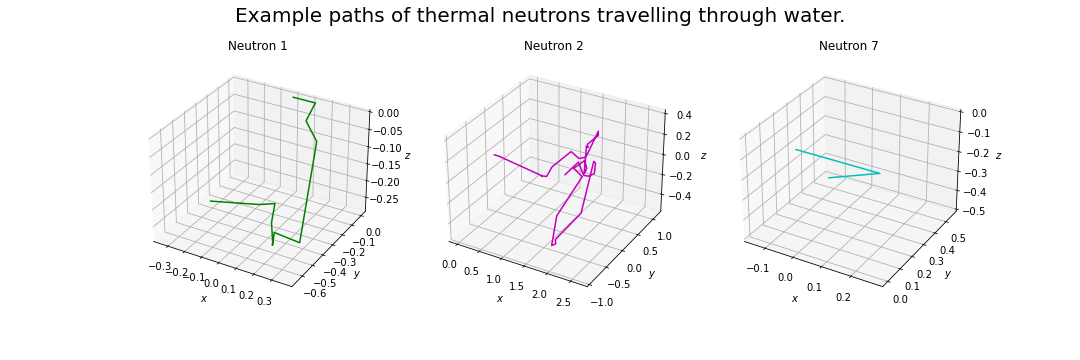

0.20% of the neutrons have been transmitted.
19.90% of the neutrons have been absorbed.
79.90% of the neutrons have been reflected.


<IPython.core.display.Javascript object>


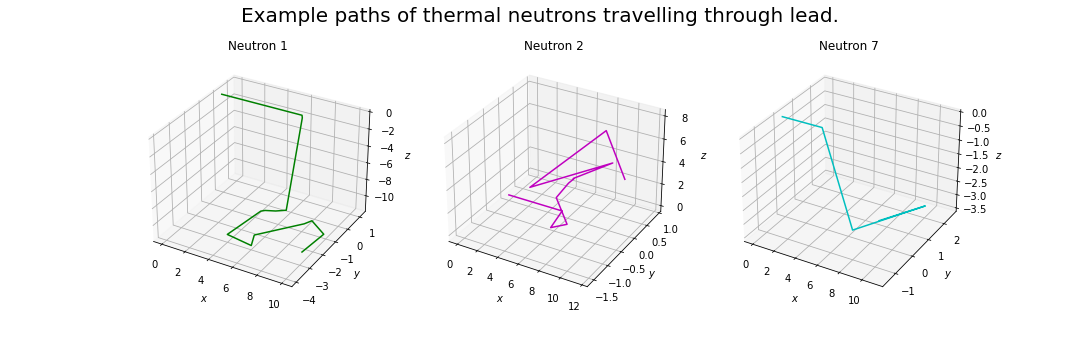

31.10% of the neutrons have been transmitted.
10.10% of the neutrons have been absorbed.
58.80% of the neutrons have been reflected.


<IPython.core.display.Javascript object>


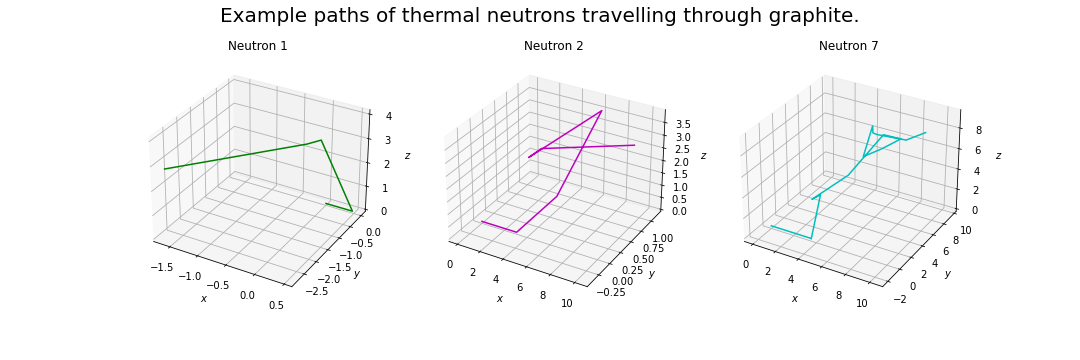

30.10% of the neutrons have been transmitted.
0.60% of the neutrons have been absorbed.
69.30% of the neutrons have been reflected.


In [21]:
N = 1000
neutron_history(N, WATER_P_ABSORPTION, WATER_MFP_TOTAL, 'water.')
neutron_history(N, LEAD_P_ABSORPTION, LEAD_MFP_TOTAL, 'lead.')
neutron_history(N, GRAPHITE_P_ABSORPTION, GRAPHITE_MFP_TOTAL, 'graphite.')

Again, when testing a larger sample size of 1000 neutrons our observations from the sample of 10 are confirmed. In all three materials mmost particles are scattered and very few are absorbed. Lead and water absorb more neutrons than graphite which agrees with our prediction. 

### Variation of transmission, reflection and absorption ratios with thickness
Next I will generate a random path for a neutron whilst varying the thickness of the slab it is moving through. This will impact the proportion of neutrons which are transmitted as with decreasing thickness more neutrons will be likely to reach the other side of the medium. I will plot the ratios of transmitted, absorbed, and reflected neutrons against a range of thicknesses for the three different materials. In order to increase to estimate the precision of the results I will repeat the investigation multiple times and produce a few arrays of numbers for each value. 

In [87]:
def mean_std_calc(ratios, n):
    means = np.array([])
    stds = np.array([])
    for i in range(0, 10):
        ratios_at_t = np.array([])
        for j in range(0, n):
            ratios_at_t = np.append(ratios_at_t, ratios[i+n*j])
        means = np.append(means, np.mean(ratios_at_t))
        stds = np.append(stds, np.std(ratios_at_t))
    return means, stds 
    
def scatter_plot(x, y, y_err, title, xname, yname):
    plt.errorbar(x, y, yerr=y_err, fmt='.')
    plt.title(title)
    plt.xlabel(xname)
    plt.ylabel(yname)

def thickness_investigation(p_absorption, mfp_total, thicknesses):
    ratio_absorbed_array = np.array([])
    ratio_transmitted_array = np.array([])
    ratio_reflected_array = np.array([])
    for t in thicknesses:
        # Add counters for how many neutrons are bsorbed, trnasmitted and reflected
        n_a, n_t, n_r = 0, 0, 0
        # Consider each neutron's path
        for neutron in range(1, N+1):
            x_path, y_path, z_path, n_a, n_t, n_r = neutron_path(t, p_absorption, mfp_total, neutron, n_a, n_t, n_r)
        # Calculate the ratios to be plotted
        ratio_absorbed_array = np.append(ratio_absorbed_array, n_a/N)
        ratio_transmitted_array = np.append(ratio_transmitted_array, n_t/N)
        ratio_reflected_array = np.append(ratio_reflected_array, n_r/N)
        
    return ratio_absorbed_array, ratio_transmitted_array, ratio_reflected_array

def ratios_calculations(p_absorption, mfp_total, thickness_data, medium):
    
    absorption_ratios = np.array([])
    transmission_ratios = np.array([])
    reflection_ratios = np.array([])

    # Get 10 repeats of each data-point to compute mean and standard deviation
    number_of_repeats = 10
    for i in range(0, number_of_repeats):
        absorption_r, transmission_r, reflection_r = thickness_investigation(p_absorption, mfp_total, thickness_data)
        absorption_ratios = np.append(absorption_ratios, absorption_r)
        transmission_ratios = np.append(transmission_ratios, transmission_r)
        reflection_ratios = np.append(reflection_ratios, reflection_r)

    mean_absorption_ratios, std_absorption_ratios = mean_std_calc(absorption_ratios, number_of_repeats)
    mean_transmission_ratios, std_transmission_ratios = mean_std_calc(transmission_ratios, number_of_repeats)
    mean_reflection_ratios, std_reflection_ratios = mean_std_calc(reflection_ratios, number_of_repeats)
    
    return mean_absorption_ratios, std_absorption_ratios, mean_transmission_ratios, std_transmission_ratios, mean_reflection_ratios, std_reflection_ratios

In [88]:
# Number of tested neutrons sufficient for a convincing ratio
N = 100
water_thicknesses = np.linspace(1, 10, 10)
lead_thicknesses = np.linspace(1, 40, 10)
graphite_thicknesses = np.linspace(1, 30, 10)

# Obtain the three ratios for ten thicknesses for each material. Repeat this 10 times and plot the averages and std's on a scatter plot
# WATER
water_absorption_ratios, water_absorption_ratios_stds, water_transmission_ratios, water_transmission_ratios_stds, water_reflection_ratios, water_reflection_ratios_stds = ratios_calculations(WATER_P_ABSORPTION, WATER_MFP_TOTAL, np.linspace(1e-5, 1e1, 10), 'water')
# LEAD
lead_absorption_ratios, lead_absorption_ratios_stds, lead_transmission_ratios, lead_transmission_ratios_stds, lead_reflection_ratios, lead_reflection_ratios_stds = ratios_calculations(LEAD_P_ABSORPTION, LEAD_MFP_TOTAL, np.linspace(1e-5, 60, 10), 'lead')
# GRAPHITE
graphite_absorption_ratios, graphite_absorption_ratios_stds, graphite_transmission_ratios, graphite_transmission_ratios_stds, graphite_reflection_ratios, graphite_reflection_ratios_stds = ratios_calculations(GRAPHITE_P_ABSORPTION, GRAPHITE_MFP_TOTAL, np.linspace(1e-5, 1e2, 10), 'graphite')

def plot_ratios(T, r_abs, r_abs_std, r_trans, r_trans_std, r_ref, r_ref_std, medium):
    plt.figure(figsize=(15,6))
    plt.suptitle('Variation of neutron histories with the thickness of ' + medium)
    plt.subplot(1,3,1)
    scatter_plot(T, r_abs, r_abs_std, 'Variation of absorption with thickness', 'Thickness [cm]', '$N_{Absorbed}/N_{Total}$')
    plt.subplot(1,3,2)
    scatter_plot(T, r_trans, r_trans_std, 'Variation of transmission with thickness', 'Thickness [cm]', '$N_{Transmitted}/N_{Total}$')
    plt.subplot(1,3,3)
    scatter_plot(T, r_ref, r_ref_std, 'Variation of reflection with thickness', 'Thickness [cm]', '$N_{Reflected}/N_{Total}$')
    plt.show()

<IPython.core.display.Javascript object>


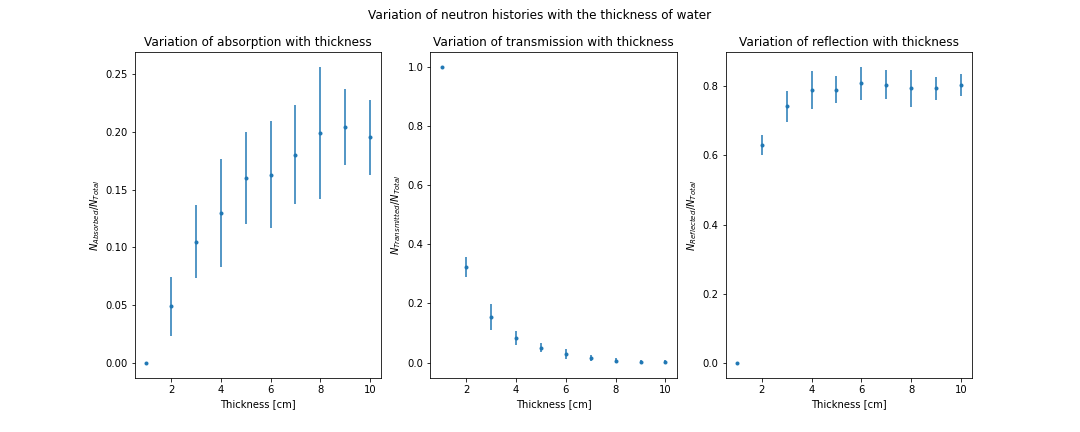

<IPython.core.display.Javascript object>


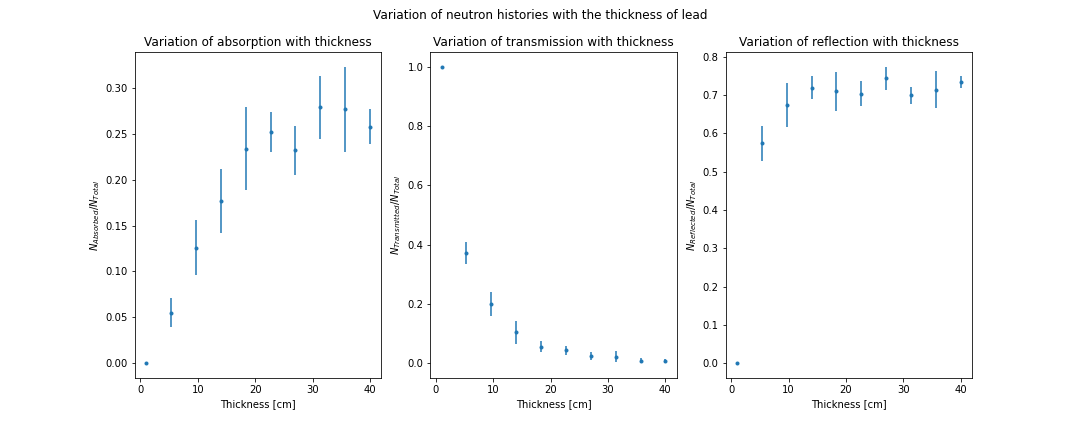

<IPython.core.display.Javascript object>


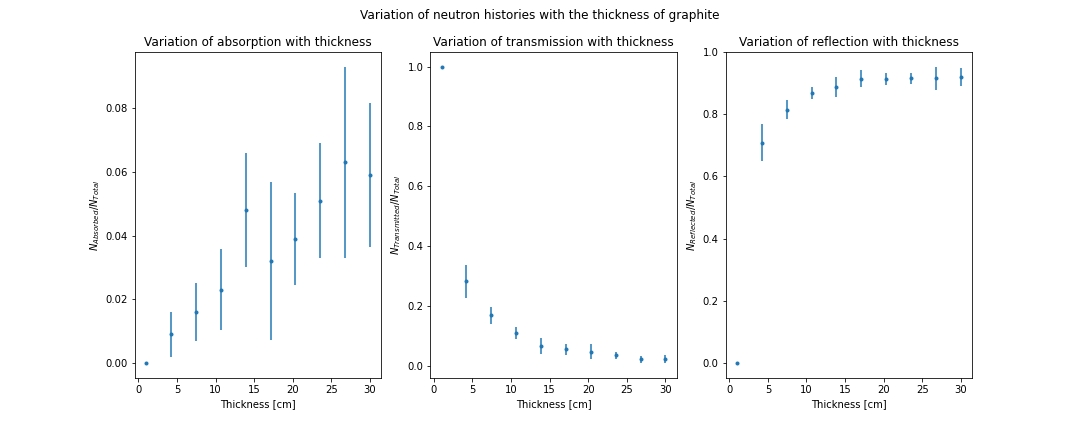

In [89]:
# Plot the three neutron ratios on a scatter diagram
plot_ratios(water_thicknesses, water_absorption_ratios, water_absorption_ratios_stds, water_transmission_ratios, water_transmission_ratios_stds, water_reflection_ratios, water_reflection_ratios_stds, 'water')
plot_ratios(lead_thicknesses, lead_absorption_ratios, lead_absorption_ratios_stds, lead_transmission_ratios, lead_transmission_ratios_stds, lead_reflection_ratios, lead_reflection_ratios_stds, 'lead')
plot_ratios(graphite_thicknesses, graphite_absorption_ratios, graphite_absorption_ratios_stds, graphite_transmission_ratios, graphite_transmission_ratios_stds, graphite_reflection_ratios, graphite_reflection_ratios_stds, 'graphite')

The first point on each graph is always the same $(0,0)$ or $(0,1)$ for transmission. When the thickness of a medium is sufficiently small all neutrons can pass right through because it is statistically too improbable for them to get absorbed in such a thin layer, and it is also more probable that ot many steps are required to reach the other side of the material, if not just one. This makes transmission much more likely than reflection. 

### Characteristic attenuation lengths
Next I will use the mean values to find the attenuation depth of each medium. I will linearize the data and fit it to the  equation:
$$ln{\frac{N}{N_{0}}}=-\frac{1}{\lambda}T$$
where $T$ is the thickness, $N_{0}$ is the total number of neutrons going into the sample, and $N$ is the number of particles absorbed. From this I can find the attenuation depth of each material $\lambda$.

The fitted attenuation depth of  water  is  1.643462626138962 +/- 0.05457055098518564


<IPython.core.display.Javascript object>


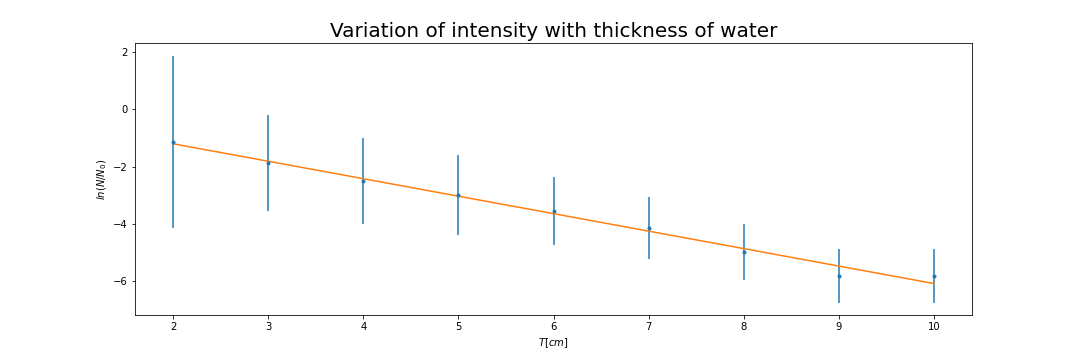

The fitted attenuation depth of  lead  is  8.970122148729066 +/- 0.4668361757809262


<IPython.core.display.Javascript object>


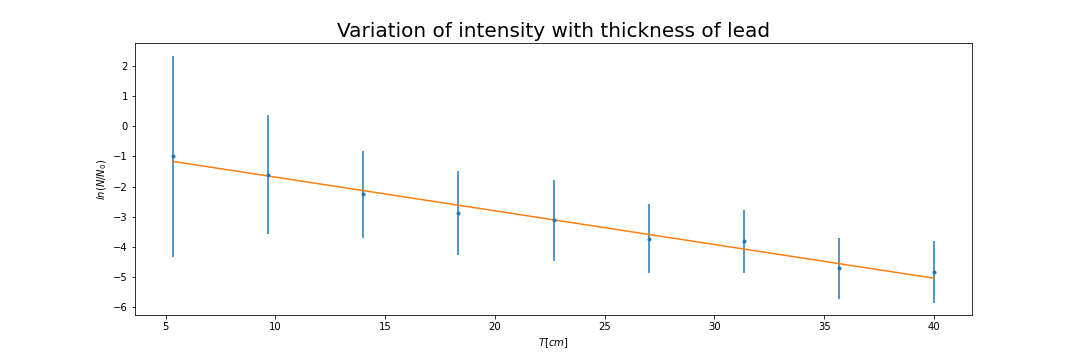

The fitted attenuation depth of  graphite  is  9.663185282518112 +/- 0.6677260894408645


<IPython.core.display.Javascript object>


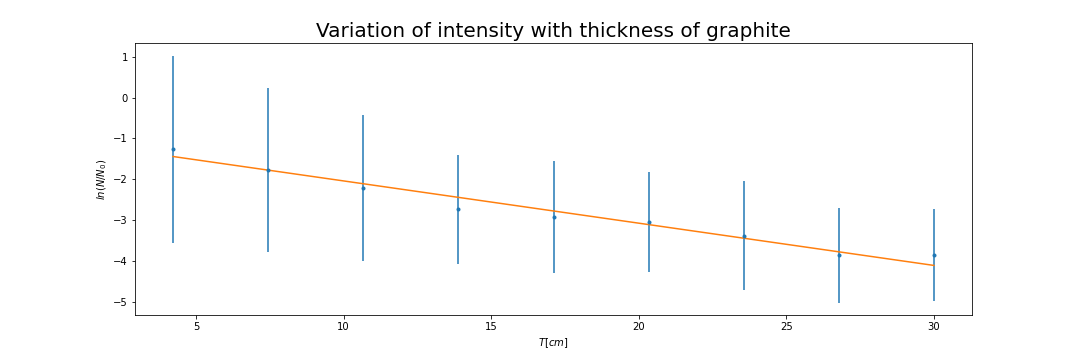

In [90]:
def attenuation_fitting(T, ratios, stds, medium):
    
    # Remove ratios which equal 0
    i = 0
    while i < len(ratios):
        if ratios[i] == 0:
            T = np.delete(T, i)
            ratios = np.delete(ratios, i)
            stds = np.delete(stds, i)
        else:
            i += 1
    # Linearise the data (=thickness/lambda) where lambda is the fitted attenuation depth of water for absorption
    ratios_linear = np.log(ratios)
    stds_linear = np.array([])
    for std in stds:
        if std != 0:
            stds_linear = np.append(stds_linear, np.log(std))
        else:
            stds_linear = np.append(stds_linear, 0)
    
    parameters, cov = np.polyfit(T[1:], ratios_linear[1:], 1, w=1/stds_linear[1:], cov=True)
    fitted_mfp = -1/parameters[0]
    mfp_error = abs((np.sqrt(cov[0][0])/parameters[0])*fitted_mfp)
    print('The fitted attenuation depth of ', medium, ' is ', fitted_mfp, '+/-', mfp_error)
    # Plot the fit
    fig = plt.figure(figsize=(15,5))
    plt.errorbar(T[1:], ratios_linear[1:], yerr=stds_linear[1:]/ratios_linear[1:], fmt='.')
    plt.plot(T[1:], parameters[0]*T[1:]+parameters[1])
    plt.title('Variation of intensity with thickness of '+ medium, fontsize=20)
    plt.xlabel('$T [cm]$')
    plt.ylabel('$ln(N/N_{0})$')
    plt.show()
    
    return fitted_mfp, mfp_error, parameters


# WATER
fitted_mfp_water, fitted_mfp_error_water, water_parameters = attenuation_fitting(water_thicknesses, water_transmission_ratios, water_transmission_ratios_stds, 'water')

# LEAD
fitted_mfp_lead, fitted_mfp_error_lead, lead_parameters = attenuation_fitting(lead_thicknesses, lead_transmission_ratios, lead_transmission_ratios_stds, 'lead')

# GRAPHITE
fitted_mfp_graphite, fitted_mfp_error_graphite, graphite_parameters = attenuation_fitting(graphite_thicknesses, graphite_transmission_ratios, graphite_transmission_ratios_stds, 'graphite')

In [94]:
def reduced_chi_squared(expected, observed, error):
    return np.sum(((observed-expected)**2)/(error**2))/N

reduced_chi_water = reduced_chi_squared(np.log(water_transmission_ratios[1:]), (water_parameters[0]*water_thicknesses[1:]+water_parameters[1]), np.log(water_transmission_ratios_stds[1:])/np.log(water_transmission_ratios[1:]))
reduced_chi_lead = reduced_chi_squared(np.log(lead_transmission_ratios[1:]), (lead_parameters[0]*lead_thicknesses[1:]+lead_parameters[1]), np.log(lead_transmission_ratios_stds[1:])/np.log(lead_transmission_ratios[1:]))
reduced_chi_graphite = reduced_chi_squared(np.log(graphite_transmission_ratios[1:]), (graphite_parameters[0]*graphite_thicknesses[1:]+graphite_parameters[1]), np.log(graphite_transmission_ratios_stds[1:])/np.log(graphite_transmission_ratios[1:]))

# Summarise the final results for attenuation lengths of the three materials:
print('{a:<15}'.format(a='Material'), '{a:<35}'.format(a='Calculated attenuation depth (cm)'), '{a:<20}'.format(a='Fitted attenuation depth (cm)'), '{a:<20}'.format(a='Chi squared of the fit'))
print('-------------------------------------------------------------------------------------------------------')
print('{a:<15}'.format(a='Water'), '{:<35.2f}'.format(WATER_MFP_TOTAL), '{:<5.2f} +/- {:<20.2f}'.format(fitted_mfp_water,fitted_mfp_error_water), '{:<20}'.format(reduced_chi_water))
print('{a:<15}'.format(a='Lead'), '{:<35.2f}'.format(LEAD_MFP_TOTAL), '{:<5.2f} +/- {:<20.2f}'.format(fitted_mfp_lead,fitted_mfp_error_lead), '{:<20}'.format(reduced_chi_lead))
print('{a:<15}'.format(a='Graphite'), '{:<35.2f}'.format(GRAPHITE_MFP_TOTAL), '{:<5.2f} +/- {:<20.2f}'.format(fitted_mfp_graphite,fitted_mfp_error_graphite), '{:<20}'.format(reduced_chi_graphite))

Material        Calculated attenuation depth (cm)   Fitted attenuation depth (cm) Chi squared of the fit
-------------------------------------------------------------------------------------------------------
Water           0.29                                1.64  +/- 0.05                 0.0025400736147586024
Lead            2.66                                8.97  +/- 0.47                 0.001881451677585397
Graphite        2.52                                9.66  +/- 0.67                 0.0012450905956751445


The reduced chi squared values are very low (hence I have not rounded them) which suggest a high accuracy of fit. They are well below 1 and only get more encouraging as I put more neutrons through the simulation. 

### Conclusion
I have obtained fitted values for attenuation lengths of water, lead and graphite by using 5000 neutrons after leaving the program to run for a long period of time. In this way the accuracy is maximised. Belowe are the computed results:


| Material | Fitted attenuation depth (cm) | Analytical attenuation depth (cm) |
| :- | :-: | :-: |
| Water | 1.7734049984344993 +/- 0.030901918194415973 | 0.28857395004375297 |
|Lead | 8.210429223446829 +/- 0.11821850670890106 | 2.664028641665988 |
| Graphite | 10.128138620967382 +/- 0.5917294451669501 | 2.517158105427453 |

Water has the lowest attenuation lengths when all processes are considered and lead and graphite have similar, but higher values. These agree with the calculated probabilities of absorption, as water had the analytically-calculated shortest mean free path and lead and graphite had higher and similar values for this property.


## Scattering over material boundary

So far I have considered only on ematerial at a time, and hence I only had to work with one value of lambda. The method described above will unfortunately not work for a neutron scattered in a medium which changes $\lambda$. Therefore, next I will consider 

### EGS Sampling

EGS (Electron Gamma Sampling) is a method of generating samples 
Firstly I will calculate the probability distribution for each process using the mean free path calculated for each process::
$$P[x_{a}]=e^{-x/\lambda_{a}}, P[x_{s}]=e^{-x/\lambda_{s}}$$
Next, instead of generating one step size $s_{i}$, I will generate two step sizes: $s_{a}=-\lambda_{a}log(u_{i})$ and $s_{s}=-\lambda_{s}log(u_{i})$. And out of these two we choose the shortest distance, and in this way determine which process (absorption or scattering) took place. $s_{i}=min[s_{a},s_{s}]$. However this method produces biased steps when a neutron goes to a different medium than before. The program would need to check what mean free path to use and calculate it in every cross-section. Therefore, a method called Woodcock Tracking is used to eliminate the bias. 

### Woodcock method

I will choose the majorant cross-section, $\Sigma_{T}=max(\Sigma_{1},\Sigma_{2})$, and take steps according to that. 
$$s_{i}=-\lambda_{T}log(u_{i})$$
However, not all steps will lead to one of the processes considered before when a neutron is inside a medium with the longer mfp to account for the advantage caused by using the shorter$\lambda$. Some steps will do nothing (no scattering or absorption)- these are fictitious steps.
Fictitious steps occur when the macroscopic cross-section of a medium, $\Sigma_{1}$, leads to a probability smaller than a randomly generated number. Those steps lead to neither scattering nor absorption. 
$$P[f]=\frac{\Sigma_{f}}{\Sigma_{T}}=\frac{\Sigma_{T}-\Sigma_{1}}{\Sigma_{T}}=1-\frac{\Sigma_{1}}{\Sigma_{T}}$$
The step is real when the probability of a process, $P[1]=\frac{\Sigma_{1}}{\Sigma_{T}}$ is larger than the threshold $v$. If it is decided that the step is real the following process has to be decided out of absorption and scattering. This is done based on the macroscopic cross-sections of the two processes. If a random number $u$ is smaller than the probability of one process (e.g. absorption), then the other process occurs (scattering).

In the following investigation I will use the Woodcock method to calculate the fraction of neutrons transmitted through two slabs of different materials in contact with each other, each of thickness 10cm. 

<IPython.core.display.Javascript object>


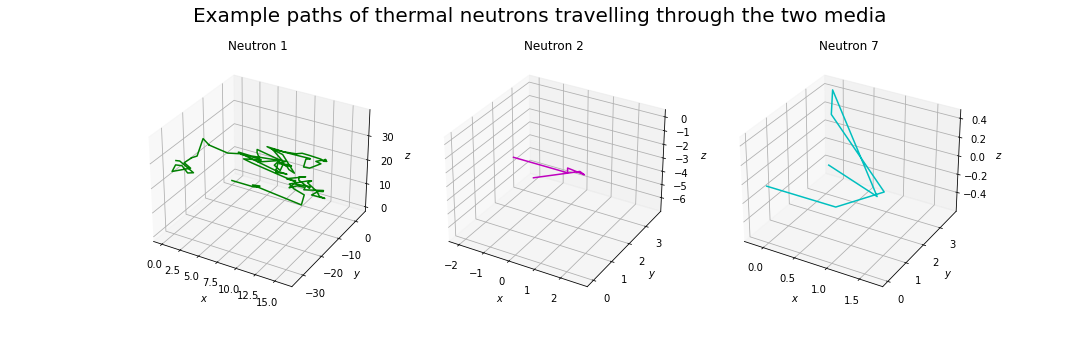

10.00% of the neutrons have been transmitted.
0.00% of the neutrons have been absorbed.
90.00% of the neutrons have been reflected.


In [95]:
# Decide the parameters of the two materials used in the investigation
MFP_1 = 5 #[cm]
XS_1 = 1/MFP_1
THICKNESS_1 = 10 #[cm]
P_ABSORPTION_1 = 0.001
MFP_2 = 1.5 #[cm]
XS_2 = 1/MFP_2
THICKNESS_2 = 10 #[cm]
P_ABSORPTION_2 = 0.0001

# Let N be the number of neutrons being sent into the media
N = 10

# max macrospic cross-section -> min mean free path 
# decide which mean free path is smaller and use it to generate an array of step sizes
if MFP_1 < MFP_2:
    MFP_MIN = MFP_1
else:
    MFP_MIN = MFP_2

def woodcock_step(r, theta, phi, step_type):
    if step_type == 'real':
        theta = np.arccos(1-2*np.random.uniform(0, 1, 1))
        phi = np.random.uniform(0, 2*np.pi, 1)
    # Convert to cartesian 
    x_step = r*np.sin(theta)*np.cos(phi)
    y_step = r*np.sin(theta)*np.sin(phi)
    z_step = r*np.cos(theta)
    # Returns an array of random step coordinates
    return x_step, y_step, z_step, theta, phi

def check_for_absorption(x, n_a, is_absorbed, p_a):
    u = np.random.uniform(0,1,1)
    if u < p_a:
        is_absorbed = True
        n_a += 1
    return n_a, is_absorbed
    
def woodcock_method(n_a, n_t, n_r):
    # Counter for the number of steps
    n = 0 
    # Initial coordinates
    x = np.array([0.])
    y = np.array([0.,0.])
    z = np.array([0.,0.])
    is_absorbed = False
    theta = 0
    phi = 0
    while x[-1] >= 0 and x[-1] < (THICKNESS_1+THICKNESS_2) and is_absorbed == False:
        if x[-1] < THICKNESS_1:
            p_absorption = P_ABSORPTION_1
        else:
            p_absorption = P_ABSORPTION_2
        # Initial step has to be in the positive x direction
        if n == 0:
            x = np.append(x, random_exponential_array(MFP_MIN, 0, 1, 1))
            n_a, is_absorbed = check_for_absorption(x[-1], n_a, is_absorbed, p_absorption)
        else:
            # Generate a random step size
            s_i = random_exponential_array(MFP_MIN, 0, 1, 1)
            # Check which material the particle is in (larger or smaller mean free path)
            # If it's in the medium with a longer mfp check whether to take a real or fictitious step
            if MFP_1 != MFP_MIN:
                u_j = np.random.uniform(0,1,1)
                if u_j < XS_1/(XS_1+XS_2):
                    # Fictitious displacement
                    s_x, s_y, s_z, theta, phi = woodcock_step(s_i, theta, phi, 'fictitious')
                    x = np.append(x, x[-1]+s_x)
                    y = np.append(y, y[-1]+s_y)
                    z = np.append(z, z[-1]+s_z)
                else:
                    # Real displacement
                    s_x, s_y, s_z, theta, phi = woodcock_step(s_i, theta, phi, 'real')
                    x = np.append(x, x[-1]+s_x)
                    y = np.append(y, y[-1]+s_y)
                    z = np.append(z, z[-1]+s_z)
                    if x[-1] < 0 and x[-1] > (THICKNESS_1+THICKNESS_2):
                        n_a, is_absorbed = check_for_absorption(x[-1],n_a, is_absorbed, p_absorption)
            else:
                s_x, s_y, s_z, theta, phi = woodcock_step(s_i, theta, phi, 'real')
                x = np.append(x, x[-1]+s_x)
                y = np.append(y, y[-1]+s_y)
                z = np.append(z, z[-1]+s_z)
                if x[-1] < 0 and x[-1] > (THICKNESS_1+THICKNESS_2):
                    n_a, is_absorbed = check_for_absorption(x[-1], n_a, is_absorbed, p_absorption)
        if is_absorbed == True:
            break
        elif x[-1] < 0:
            n_r += 1 
            break
        elif x[-1] > (THICKNESS_1+THICKNESS_2):
            n_t += 1
            break
        n += 1
    return x, y, z, n_a, n_t, n_r

def neutron_history_woodcock(neutron_number):
    fig = plt.figure(figsize=(15,5))
    fig.suptitle('Example paths of thermal neutrons travelling through the two media', fontsize=20)
    i = 1
    # Add counters for how many neutrons are bsorbed, trnasmitted and reflected
    n_a, n_t, n_r = 0, 0, 0
    # Consider each neutron's path
    for neutron in range(1, neutron_number+1):
        x_path, y_path, z_path, n_a, n_t, n_r = woodcock_method(n_a, n_t, n_r)
        # plot a path of a few example neutrons (e.g. the 1st, the 2nd, and the 7th)
        if neutron == 1 or neutron == 2 or neutron == 7:
            ax = fig.add_subplot(1,3,i, projection='3d')
            ax.plot3D(x_path, y_path, z_path, c=colour_list[i-1])
            plt.title('Neutron '+str(neutron))
            ax.set_xlabel('$x$')
            ax.set_ylabel('$y$')
            ax.set_zlabel('$z$')
            i += 1
    plt.show()
    neutron_path_analysis(n_a, n_t, n_r)
    
def neutron_path_analysis(n_absorbed, n_transmitted, n_reflected):
    print("{:.2f}".format(n_transmitted/N*100)+'% of the neutrons have been transmitted.')
    print("{:.2f}".format(n_absorbed/N*100)+'% of the neutrons have been absorbed.')
    print("{:.2f}".format(n_reflected/N*100)+'% of the neutrons have been reflected.')

neutron_history_woodcock(N)

### <img src="bee.png" align="center"/><br><br>